# Connect to Local SQL Server Database
This section demonstrates how to connect to your local SQL Server database using Python.

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, inspect
import json
import ast
import matplotlib.pyplot as plt

In [2]:
# Safely parse the similarity_metrics column, handling both single and double quotes
def safe_json_loads(val):
    try:
        return json.loads(val)
    except json.JSONDecodeError:
        try:
            return ast.literal_eval(val)
        except Exception:
            return {}

In [3]:
# Filtering function
def filter_function(example):
    return example['structurized_answer_start_index'] != -1

## Retrieve Data

In [4]:
# Connection parameters
server = '192.168.0.102' # VPN: '10.0.0.2'
database = 'Thesis'
username = 'sa'
password = 'e1r2e3n4'

In [5]:
# Create SQLAlchemy engine for SQL Server using pymssql
engine = create_engine(f"mssql+pymssql://{username}:{password}@{server}:1433/{database}")

In [6]:
# Use SQLAlchemy's inspect to get all table names
inspector = inspect(engine)
table_names = inspector.get_table_names()
print('Tables found:\n', "\n".join(table_names), sep="")

Tables found:
squad_structured_train
squad_structured_validation
temp_train_metrics_update
temp_validation_metrics_update
train_answer_predictions
unique_squad_train_context
unique_squad_validation_context
validation_answer_predictions


In [7]:
# Retrieve data from all tables into separate DataFrames
dataframes = {}
for table in table_names:
    if "structured" in table:
        try:
            df = pd.read_sql(f'SELECT * FROM {table}', engine)
            dataframes[table] = df
            print(f"Loaded {table} into DataFrame with {len(df)} rows.")
        except Exception as e:
            print(f"Failed to load {table}: {e}")

Loaded squad_structured_train into DataFrame with 87599 rows.
Loaded squad_structured_validation into DataFrame with 10570 rows.


## Train Set

In [8]:
df_st_all = dataframes["squad_structured_train"]

In [9]:
df_st_all.columns

Index(['squad_id', 'title', 'context', 'structurized_context', 'question',
       'answer_text', 'answer_start_index', 'structurized_answer_start_index',
       'similarity_metrics'],
      dtype='object')

In [10]:
df_st_filtered = df_st_all[df_st_all["structurized_answer_start_index"] != -1]

In [11]:
print(df_st_all.count())
print(df_st_filtered.count())

squad_id                           87599
title                              87599
context                            87599
structurized_context               87599
question                           87599
answer_text                        87599
answer_start_index                 87599
structurized_answer_start_index    87599
similarity_metrics                 87599
dtype: int64
squad_id                           67700
title                              67700
context                            67700
structurized_context               67700
question                           67700
answer_text                        67700
answer_start_index                 67700
structurized_answer_start_index    67700
similarity_metrics                 67700
dtype: int64


In [12]:
df_st_all = df_st_all.drop(columns=["structurized_context", "question", "answer_text", "answer_start_index", "structurized_answer_start_index"])
df_st_filtered = df_st_filtered.drop(columns=["structurized_context", "question", "answer_text", "answer_start_index", "structurized_answer_start_index"])

In [13]:
print(df_st_all.columns)
print(df_st_filtered.columns)

Index(['squad_id', 'title', 'context', 'similarity_metrics'], dtype='object')
Index(['squad_id', 'title', 'context', 'similarity_metrics'], dtype='object')


In [14]:
# Show DataFrame grouped by 'context' with unique rows
df_st_all_unique = df_st_all.drop_duplicates(subset=['context'])
df_st_all_unique = df_st_all_unique.reset_index(drop=True)
df_st_filtered_unique = df_st_filtered.drop_duplicates(subset=['context'])
df_st_filtered_unique = df_st_filtered_unique.reset_index(drop=True)
df_st_filtered_unique

,squad_id,title,context,similarity_metrics
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/bi:'j?nseI/ b...,"{'colbert': [0.8973691463470459], 'sparse': [2..."
1,56be86cf3aeaaa14008c9076,Beyoncé,Following the disbandment of Destiny's Child i...,"{'colbert': [0.9272266030311584], 'sparse': [2..."
2,56be88473aeaaa14008c9080,Beyoncé,"A self-described ""modern-day feminist"", Beyonc...","{'colbert': [0.9256731271743774], 'sparse': [2..."
3,56be892d3aeaaa14008c908b,Beyoncé,"Beyoncé Giselle Knowles was born in Houston, T...","{'colbert': [0.9348885416984558], 'sparse': [2..."
4,56be8a583aeaaa14008c9094,Beyoncé,Beyoncé attended St. Mary's Elementary School ...,"{'colbert': [0.925513505935669], 'sparse': [1...."
...,...,...,...,...
18376,5735d07d012e2f140011a087,Kathmandu,Football and Cricket are the most popular spor...,"{'colbert': [0.9161341190338135], 'sparse': [1..."
18377,5735d0f46c16ec1900b92823,Kathmandu,The total length of roads in Nepal is recorded...,"{'colbert': [0.8502343893051147], 'sparse': [1..."
18378,5735d1a86c16ec1900b92831,Kathmandu,The main international airport serving Kathman...,"{'colbert': [0.8344689607620239], 'sparse': [1..."
18379,5735d259012e2f140011a09d,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...","{'colbert': [0.8707681894302368], 'sparse': [1..."


In [ ]:
# template to add similarity metrics
# similarity_metrics_df = unique_df["similarity_metrics"].apply(safe_json_loads).apply(pd.Series)
# unique_df = pd.concat([unique_df, similarity_metrics_df], axis=1)

In [16]:
df_st_all_unique_similarity_metrics = df_st_all_unique["similarity_metrics"].apply(safe_json_loads).apply(pd.Series)
df_st_all_unique = pd.concat([df_st_all_unique, df_st_all_unique_similarity_metrics], axis=1)

df_st_filtered_unique_similarity_metrics = df_st_filtered_unique["similarity_metrics"].apply(safe_json_loads).apply(pd.Series)
df_st_filtered_unique = pd.concat([df_st_filtered_unique, df_st_filtered_unique_similarity_metrics], axis=1)

In [17]:
print(df_st_all_unique.count())
print(df_st_filtered_unique.count())

squad_id                18891
title                   18891
context                 18891
similarity_metrics      18891
colbert                 18891
sparse                  18891
dense                   18891
sparse+dense            18891
colbert+sparse+dense    18891
dtype: int64
squad_id                18381
title                   18381
context                 18381
similarity_metrics      18381
colbert                 18381
sparse                  18381
dense                   18381
sparse+dense            18381
colbert+sparse+dense    18381
dtype: int64


In [45]:
# # If any of the similarity_metrics columns are lists, extract the first element
# for col in similarity_metrics_df.columns:
#     if similarity_metrics_df[col].apply(lambda x: isinstance(x, list)).any():
#         similarity_metrics_df[col] = similarity_metrics_df[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# # Update unique_df with the processed columns
# unique_df = pd.concat([unique_df.drop(columns=similarity_metrics_df.columns, errors='ignore'), similarity_metrics_df], axis=1)
# unique_df

In [18]:
# If any of the similarity_metrics columns are lists, extract the first element
for col in df_st_all_unique_similarity_metrics.columns:
    if df_st_all_unique_similarity_metrics[col].apply(lambda x: isinstance(x, list)).any():
        df_st_all_unique_similarity_metrics[col] = df_st_all_unique_similarity_metrics[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Update unique_df with the processed columns
df_st_all_unique = pd.concat([df_st_all_unique.drop(columns=df_st_all_unique_similarity_metrics.columns, errors='ignore'), df_st_all_unique_similarity_metrics], axis=1)
df_st_all_unique

,squad_id,title,context,similarity_metrics,colbert,sparse,dense,sparse+dense,colbert+sparse+dense
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/bi:'j?nseI/ b...,"{'colbert': [0.8973691463470459], 'sparse': [2...",0.897369,2.332031,0.919922,1.625977,1.383108
1,56be86cf3aeaaa14008c9076,Beyoncé,Following the disbandment of Destiny's Child i...,"{'colbert': [0.9272266030311584], 'sparse': [2...",0.927227,2.279297,0.932129,1.605713,1.379551
2,56be88473aeaaa14008c9080,Beyoncé,"A self-described ""modern-day feminist"", Beyonc...","{'colbert': [0.9256731271743774], 'sparse': [2...",0.925673,2.408203,0.930176,1.669189,1.421351
3,56be892d3aeaaa14008c908b,Beyoncé,"Beyoncé Giselle Knowles was born in Houston, T...","{'colbert': [0.9348885416984558], 'sparse': [2...",0.934889,2.060547,0.951660,1.506104,1.315699
4,56be8a583aeaaa14008c9094,Beyoncé,Beyoncé attended St. Mary's Elementary School ...,"{'colbert': [0.925513505935669], 'sparse': [1....",0.925514,1.320312,0.931152,1.125732,1.058993
...,...,...,...,...,...,...,...,...,...
18886,5735d0026c16ec1900b92815,Kathmandu,"Institute of Medicine, the central college of ...","{'colbert': [0.87876957654953], 'sparse': [1.0...",0.878770,1.053711,0.934082,0.993896,0.955521
18887,5735d07d012e2f140011a087,Kathmandu,Football and Cricket are the most popular spor...,"{'colbert': [0.9161341190338135], 'sparse': [1...",0.916134,1.866211,0.936035,1.401123,1.239460
18888,5735d0f46c16ec1900b92823,Kathmandu,The total length of roads in Nepal is recorded...,"{'colbert': [0.8502343893051147], 'sparse': [1...",0.850234,1.167969,0.884277,1.026123,0.967494
18889,5735d1a86c16ec1900b92831,Kathmandu,The main international airport serving Kathman...,"{'colbert': [0.8344689607620239], 'sparse': [1...",0.834469,1.852539,0.873535,1.363037,1.186848


In [19]:
# If any of the similarity_metrics columns are lists, extract the first element
for col in df_st_filtered_unique_similarity_metrics.columns:
    if df_st_filtered_unique_similarity_metrics[col].apply(lambda x: isinstance(x, list)).any():
        df_st_filtered_unique_similarity_metrics[col] = df_st_filtered_unique_similarity_metrics[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Update unique_df with the processed columns
df_st_filtered_unique = pd.concat([df_st_filtered_unique.drop(columns=df_st_filtered_unique_similarity_metrics.columns, errors='ignore'), df_st_filtered_unique_similarity_metrics], axis=1)
df_st_filtered_unique

,squad_id,title,context,similarity_metrics,colbert,sparse,dense,sparse+dense,colbert+sparse+dense
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/bi:'j?nseI/ b...,"{'colbert': [0.8973691463470459], 'sparse': [2...",0.897369,2.332031,0.919922,1.625977,1.383108
1,56be86cf3aeaaa14008c9076,Beyoncé,Following the disbandment of Destiny's Child i...,"{'colbert': [0.9272266030311584], 'sparse': [2...",0.927227,2.279297,0.932129,1.605713,1.379551
2,56be88473aeaaa14008c9080,Beyoncé,"A self-described ""modern-day feminist"", Beyonc...","{'colbert': [0.9256731271743774], 'sparse': [2...",0.925673,2.408203,0.930176,1.669189,1.421351
3,56be892d3aeaaa14008c908b,Beyoncé,"Beyoncé Giselle Knowles was born in Houston, T...","{'colbert': [0.9348885416984558], 'sparse': [2...",0.934889,2.060547,0.951660,1.506104,1.315699
4,56be8a583aeaaa14008c9094,Beyoncé,Beyoncé attended St. Mary's Elementary School ...,"{'colbert': [0.925513505935669], 'sparse': [1....",0.925514,1.320312,0.931152,1.125732,1.058993
...,...,...,...,...,...,...,...,...,...
18376,5735d07d012e2f140011a087,Kathmandu,Football and Cricket are the most popular spor...,"{'colbert': [0.9161341190338135], 'sparse': [1...",0.916134,1.866211,0.936035,1.401123,1.239460
18377,5735d0f46c16ec1900b92823,Kathmandu,The total length of roads in Nepal is recorded...,"{'colbert': [0.8502343893051147], 'sparse': [1...",0.850234,1.167969,0.884277,1.026123,0.967494
18378,5735d1a86c16ec1900b92831,Kathmandu,The main international airport serving Kathman...,"{'colbert': [0.8344689607620239], 'sparse': [1...",0.834469,1.852539,0.873535,1.363037,1.186848
18379,5735d259012e2f140011a09d,Kathmandu,"Kathmandu Metropolitan City (KMC), in order to...","{'colbert': [0.8707681894302368], 'sparse': [1...",0.870768,1.117188,0.900879,1.009033,0.962945


In [21]:
print(df_st_filtered_unique["sparse"].min(), df_st_filtered_unique["sparse"].mean(), df_st_filtered_unique["sparse"].max())

0.1585693359375 1.1540552978449214 3.89453125


In [49]:
print("df unfiltered unique contexts similarity averages: ", df_st_all_unique["colbert"].mean(), df_st_all_unique["sparse"].mean(), df_st_all_unique["dense"].mean())
print("df filtered unique contexts similarity averages: ", df_st_filtered_unique["colbert"].mean(), df_st_filtered_unique["sparse"].mean(), df_st_filtered_unique["dense"].mean())

df unfiltered unique contexts similarity averages:  0.8751617661713733 1.1475337590732568 0.898172565226166
df filtered unique contexts similarity averages:  0.8761057822471228 1.1540552978449214 0.8991282820915619


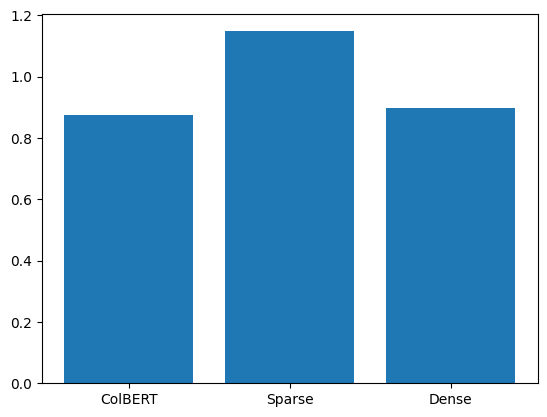

In [50]:
plt.bar(["ColBERT", "Sparse", "Dense"], [df_st_all_unique["colbert"].mean(), df_st_all_unique["sparse"].mean(), df_st_all_unique["dense"].mean()])
plt.show()

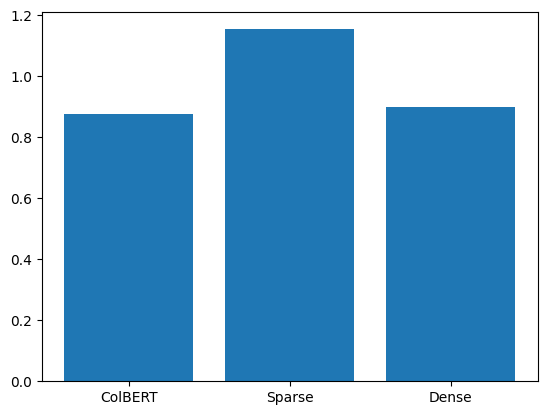

In [51]:
plt.bar(["ColBERT", "Sparse", "Dense"], [df_st_filtered_unique["colbert"].mean(), df_st_filtered_unique["sparse"].mean(), df_st_filtered_unique["dense"].mean()])
plt.show()

## Validation Set

In [56]:
df_st_val_all = dataframes["squad_structured_validation"]

In [58]:
df_st_val_all.columns

Index(['squad_id', 'title', 'context', 'structurized_context', 'question',
       'answer_text', 'answer_start_index', 'structurized_answer_start_index',
       'similarity_metrics'],
      dtype='object')

In [75]:
df_st_val_filtered = df_st_val_all[df_st_val_all["structurized_answer_start_index"].notna()]

In [76]:
print(df_st_val_all.count())
print(df_st_val_filtered.count())

squad_id                           10570
title                              10570
context                            10570
structurized_context               10570
question                           10570
answer_text                        10570
answer_start_index                 10570
structurized_answer_start_index     4832
similarity_metrics                 10570
dtype: int64
squad_id                           4832
title                              4832
context                            4832
structurized_context               4832
question                           4832
answer_text                        4832
answer_start_index                 4832
structurized_answer_start_index    4832
similarity_metrics                 4832
dtype: int64


In [77]:
df_st_val_all = df_st_val_all.drop(columns=["structurized_context", "question", "answer_text", "answer_start_index", "structurized_answer_start_index"])
df_st_val_filtered = df_st_val_filtered.drop(columns=["structurized_context", "question", "answer_text", "answer_start_index", "structurized_answer_start_index"])

In [78]:
df_st_val_all_unique = df_st_val_all.drop_duplicates(subset=['context'])
df_st_val_all_unique = df_st_val_all_unique.reset_index(drop=True)

df_st_val_filtered_unique = df_st_val_filtered.drop_duplicates(subset=['context'])
df_st_val_filtered_unique = df_st_val_filtered_unique.reset_index(drop=True)

In [79]:
df_st_val_all_unique_similarity_metrics = df_st_val_all_unique["similarity_metrics"].apply(safe_json_loads).apply(pd.Series)
df_st_val_all_unique = pd.concat([df_st_val_all_unique, df_st_val_all_unique_similarity_metrics], axis=1)

df_st_val_filtered_unique_similarity_metrics = df_st_val_filtered_unique["similarity_metrics"].apply(safe_json_loads).apply(pd.Series)
df_st_val_filtered_unique = pd.concat([df_st_val_filtered_unique, df_st_val_filtered_unique_similarity_metrics], axis=1)

In [80]:
# If any of the similarity_metrics columns are lists, extract the first element
for col in df_st_val_all_unique_similarity_metrics.columns:
    if df_st_val_all_unique_similarity_metrics[col].apply(lambda x: isinstance(x, list)).any():
        df_st_val_all_unique_similarity_metrics[col] = df_st_val_all_unique_similarity_metrics[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Update unique_df with the processed columns
df_st_val_all_unique = pd.concat([df_st_val_all_unique.drop(columns=df_st_val_all_unique_similarity_metrics.columns, errors='ignore'), df_st_val_all_unique_similarity_metrics], axis=1)

# If any of the similarity_metrics columns are lists, extract the first element
for col in df_st_val_filtered_unique_similarity_metrics.columns:
    if df_st_val_filtered_unique_similarity_metrics[col].apply(lambda x: isinstance(x, list)).any():
        df_st_val_filtered_unique_similarity_metrics[col] = df_st_val_filtered_unique_similarity_metrics[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)

# Update unique_df with the processed columns
df_st_val_filtered_unique = pd.concat([df_st_val_filtered_unique.drop(columns=df_st_val_filtered_unique_similarity_metrics.columns, errors='ignore'), df_st_val_filtered_unique_similarity_metrics], axis=1)

In [96]:
print(df_st_val_all_unique.count())
print(df_st_val_filtered_unique.count())

squad_id                2067
title                   2067
context                 2067
similarity_metrics      2067
colbert                 2067
sparse                  2067
dense                   2067
sparse+dense            2067
colbert+sparse+dense    2067
dtype: int64
squad_id                869
title                   869
context                 869
similarity_metrics      869
colbert                 869
sparse                  869
dense                   869
sparse+dense            869
colbert+sparse+dense    869
dtype: int64


In [81]:
print(df_st_val_all_unique["colbert"].mean(), df_st_val_all_unique["sparse"].mean(), df_st_val_all_unique["dense"].mean())
print(df_st_val_filtered_unique["colbert"].mean(), df_st_val_filtered_unique["sparse"].mean(), df_st_val_filtered_unique["dense"].mean())

0.885697421614652 1.2473139806709603 0.9067777311623125
0.8982535504636336 1.273408281789413 0.919247046713176


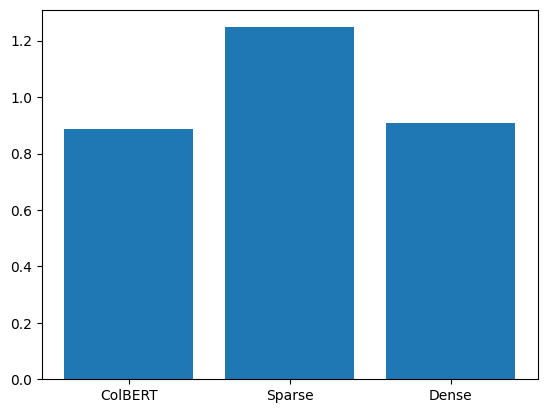

In [82]:
plt.bar(["ColBERT", "Sparse", "Dense"], [df_st_val_all_unique["colbert"].mean(), df_st_val_all_unique["sparse"].mean(), df_st_val_all_unique["dense"].mean()])
plt.show()

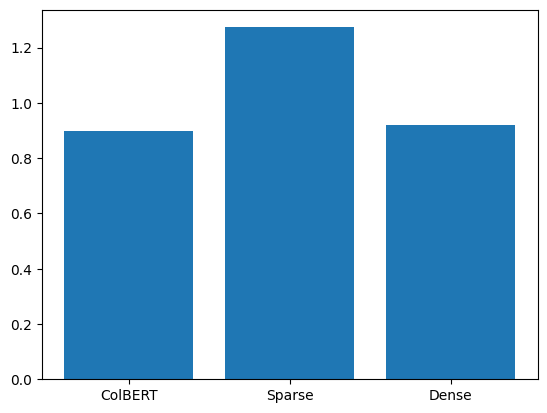

In [83]:
plt.bar(["ColBERT", "Sparse", "Dense"], [df_st_val_filtered_unique["colbert"].mean(), df_st_val_filtered_unique["sparse"].mean(), df_st_val_filtered_unique["dense"].mean()])
plt.show()

## Combined

In [93]:
metrics = ["ColBERT", "Dense", "Sparse"]
train_all_means = [df_st_all_unique[m.lower()].mean() for m in metrics]
train_all_mins = [df_st_all_unique[m.lower()].min() for m in metrics]
train_all_maxs = [df_st_all_unique[m.lower()].max() for m in metrics]
train_filtered_means = [df_st_filtered_unique[m.lower()].mean() for m in metrics]
train_filtered_mins = [df_st_filtered_unique[m.lower()].min() for m in metrics]
train_filtered_maxs = [df_st_filtered_unique[m.lower()].max() for m in metrics]
val_all_means = [df_st_val_all_unique[m.lower()].mean() for m in metrics]
val_all_mins = [df_st_val_all_unique[m.lower()].min() for m in metrics]
val_all_maxs = [df_st_val_all_unique[m.lower()].max() for m in metrics]
val_filtered_means = [df_st_val_filtered_unique[m.lower()].mean() for m in metrics]
val_filtered_mins = [df_st_val_filtered_unique[m.lower()].min() for m in metrics]
val_filtered_maxs = [df_st_val_filtered_unique[m.lower()].max() for m in metrics]

In [1]:
plot_data = {
    "Complete Train Split": {
        "means": np.array(train_all_means),
        "mins": np.array(train_all_mins),
        "maxs": np.array(train_all_maxs)
    },
    "Complete Validation Split": {
        "means": np.array(val_all_means),
        "mins": np.array(val_all_mins),
        "maxs": np.array(val_all_maxs)
    },
    "Filtered Train Split": {
        "means": np.array(train_filtered_means),
        "mins": np.array(train_filtered_mins),
        "maxs": np.array(train_filtered_maxs)
    },
    "Filtered Validation Split": {
        "means": np.array(val_filtered_means),
        "mins": np.array(val_filtered_mins),
        "maxs": np.array(val_filtered_maxs)
    }
}


# --- 3. Chart Generation ---
# This code creates a 2x2 grid of subplots for the four conditions.

# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
# fig.suptitle('Comparison of Mean Similarity Scores Between Unstructured and Structurized Contexts', fontsize=18)

# Flatten the axes array to easily iterate over it
axs = axs.flatten()

# Define colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green

# Loop through each data condition and create a bar chart on a subplot
for i, (title, values) in enumerate(plot_data.items()):
    ax = axs[i]
    means = values['means']
    mins = values['mins']
    maxs = values['maxs']

    # Calculate the error bar lengths (distance from the mean)
    # The 'yerr' parameter needs the lower error and upper error separately.
    lower_error = means - mins
    upper_error = maxs - means
    asymmetric_error = [lower_error, upper_error]

    # Create the bar chart with error bars
    ax.bar(metrics, means, yerr=asymmetric_error, capsize=5, color=colors, alpha=0.8)

    # Set labels, title, and grid for each subplot
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_ylabel('Mean Similarity Score', fontsize=12)
    ax.set_xlabel('Similarity Metric', fontsize=12)
    ax.set_ylim(bottom=0)  # Make sure the y-axis starts at 0 for clarity
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust the overall layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the final figure
plt.show()

NameError: name 'np' is not defined

In [86]:
x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

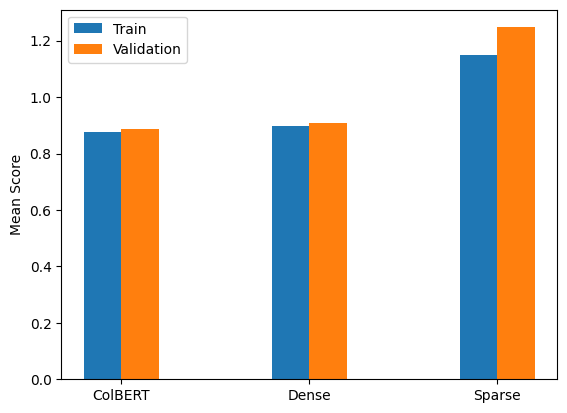

In [99]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_all_means, width, label='Train')
rects2 = ax.bar(x + width/2, val_all_means, width, label='Validation')

ax.set_ylabel('Mean Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
# plt.title('Mean Similarity Scores for Different Metrics Throughout All Dataset of Unique Contexts')
plt.show()

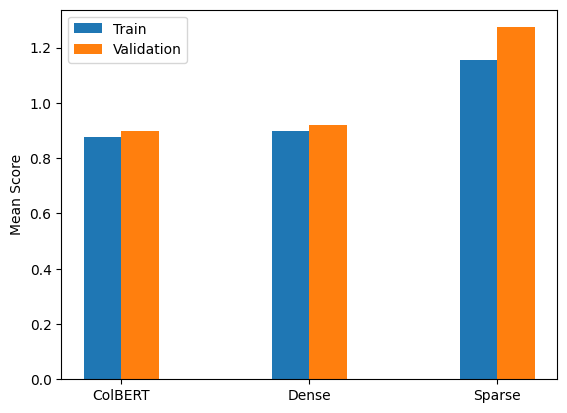

In [98]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_filtered_means, width, label='Train')
rects2 = ax.bar(x + width/2, val_filtered_means, width, label='Validation')

ax.set_ylabel('Mean Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
# plt.title('Mean Similarity Scores for Different Metrics Throughout Filtered Dataset of Unique Contexts')
plt.show()

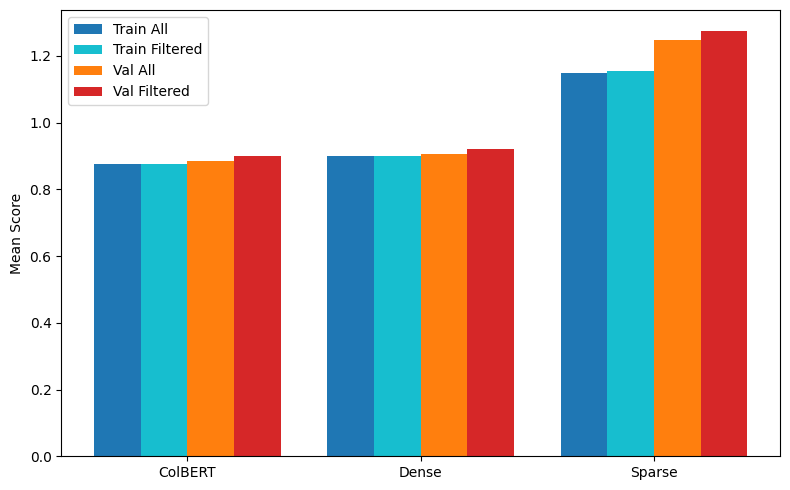

In [100]:
width = 0.2  # since we have 4 bars per group

# Prepare data in shape (num_groups, num_metrics)
means_matrix = np.array([
    train_all_means,
    train_filtered_means,
    val_all_means,
    val_filtered_means
])

labels = ['Train All', 'Train Filtered', 'Val All', 'Val Filtered']
colors = ['tab:blue', 'tab:cyan', 'tab:orange', 'tab:red']

fig, ax = plt.subplots(figsize=(8,5))

# Plot each group
for i in range(4):
    ax.bar(x + (i-1.5)*width, means_matrix[i], width, label=labels[i], color=colors[i])

ax.set_ylabel('Mean Score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
# plt.title('Mean Similarity Scores for Different Metrics (Unique Contexts)')
plt.tight_layout()
plt.show()

# Tables

In [90]:
# Table 1: All Data
table_all = pd.DataFrame(
    [train_all_means, val_all_means],
    index=['Train All', 'Val All'],
    columns=metrics
)

In [91]:
# Table 2: Filtered Data
table_filtered = pd.DataFrame(
    [train_filtered_means, val_filtered_means],
    index=['Train Filtered', 'Val Filtered'],
    columns=metrics
)

In [92]:
print("All Data Mean Similarity Scores:")
print(table_all)
print("\nFiltered Data Mean Similarity Scores:")
print(table_filtered)

All Data Mean Similarity Scores:
            ColBERT     Dense    Sparse
Train All  0.875162  0.898173  1.147534
Val All    0.885697  0.906778  1.247314

Filtered Data Mean Similarity Scores:
                 ColBERT     Dense    Sparse
Train Filtered  0.876106  0.899128  1.154055
Val Filtered    0.898254  0.919247  1.273408


In [94]:
index = ['Train All', 'Val All', 'Train Filtered', 'Val Filtered']

# Each entry: [min, mean, max] for each metric
data = [
    [train_all_mins[0], train_all_means[0], train_all_maxs[0], train_all_mins[1], train_all_means[1], train_all_maxs[1], train_all_mins[2], train_all_means[2], train_all_maxs[2]],
    [val_all_mins[0], val_all_means[0], val_all_maxs[0], val_all_mins[1], val_all_means[1], val_all_maxs[1], val_all_mins[2], val_all_means[2], val_all_maxs[2]],
    [train_filtered_mins[0], train_filtered_means[0], train_filtered_maxs[0], train_filtered_mins[1], train_filtered_means[1], train_filtered_maxs[1], train_filtered_mins[2], train_filtered_means[2], train_filtered_maxs[2]],
    [val_filtered_mins[0], val_filtered_means[0], val_filtered_maxs[0], val_filtered_mins[1], val_filtered_means[1], val_filtered_maxs[1], val_filtered_mins[2], val_filtered_means[2], val_filtered_maxs[2]]
]

columns = pd.MultiIndex.from_product(
    [metrics, ['Min', 'Mean', 'Max']]
)

table = pd.DataFrame(data, columns=columns, index=index)
print(table)

                 ColBERT                         Dense                      \
                     Min      Mean       Max       Min      Mean       Max   
Train All       0.337644  0.875162  0.959358  0.271240  0.898173  0.975098   
Val All         0.557814  0.885697  0.951385  0.548828  0.906778  0.970215   
Train Filtered  0.423769  0.876106  0.959358  0.492188  0.899128  0.975098   
Val Filtered    0.557814  0.898254  0.951385  0.548828  0.919247  0.970215   

                  Sparse                      
                     Min      Mean       Max  
Train All       0.001836  1.147534  3.894531  
Val All         0.165283  1.247314  3.523438  
Train Filtered  0.158569  1.154055  3.894531  
Val Filtered    0.165283  1.273408  3.523438  


In [97]:
table

ColBERT                         Dense                      \
                     Min      Mean       Max       Min      Mean       Max   
Train All       0.337644  0.875162  0.959358  0.271240  0.898173  0.975098   
Val All         0.557814  0.885697  0.951385  0.548828  0.906778  0.970215   
Train Filtered  0.423769  0.876106  0.959358  0.492188  0.899128  0.975098   
Val Filtered    0.557814  0.898254  0.951385  0.548828  0.919247  0.970215   

                  Sparse                      
                     Min      Mean       Max  
Train All       0.001836  1.147534  3.894531  
Val All         0.165283  1.247314  3.523438  
Train Filtered  0.158569  1.154055  3.894531  
Val Filtered    0.165283  1.273408  3.523438